# Road Accident Risk Prediction Model

_Benediktus Sashenka_

## Part 1: Package Imports

In [1]:
# General
import pandas as pd
import numpy as np

import datetime

# Data Preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sn

# Modelling
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import optuna


# Pickle variable loading
import pickle
def get_filename(var_name):
    return f'pickle/{var_name}.pkl'

def save_var(var, var_name):
    with open(get_filename(var_name), 'wb') as f:
        pickle.dump(var, f)
        
def load_var(var_name):
    with open(get_filename(var_name), 'rb') as f:
        data = pickle.load(f)
    return data

## Part 2: Data Preparation

### Useful Viz Functions

In [2]:
def subplot_hbar(ax, df, f):
    counts = df[f].value_counts().sort_values()
    counts.plot(kind="barh", width=0.8, ax=ax, fontsize=8)
    ax.set_title(f, fontsize=10)
    ax.set_xticks([])
    ax.set_ylabel("")
    
def subplot_bar(ax, df, f):
    counts = np.round(df[f],2).value_counts().sort_index()
    counts.plot(kind="bar", width=.8, ax=ax, fontsize=8)
    ax.set_title(f, fontsize=10)
    ax.tick_params(axis="x", labelrotation=0)
    ax.set_yticks([])
    ax.set_xlabel('')

def subplot_hist(ax, df, f):
    df[f].plot(kind="hist", bins=30, ax=ax, fontsize=8)
    ax.set_title(f, fontsize=10)
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')


def subplot_hboxplot(ax, df, f, target):
    names = list(df[f].value_counts().keys())
    names.sort()
    data = [df_target[df[f] == name] for name in names]
    ax.boxplot(
        data,
        tick_labels=names,
        showfliers=False,
        orientation="horizontal",
        widths=1.2,
        positions=np.arange(1, len(names) * 2, 2)
    )
    ax.set_title(f"{f} vs accident_risk", fontsize=10)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.5, len(names) * 2 + 0.5)
    ax.set_xlabel("accident_risk", fontsize=8)
    ax.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
    ax.tick_params(axis="y", labelsize=8)
    ax.tick_params(axis="x", labelsize=6)


def subplot_boxplot(ax, df, f, target):
    names = list(df[f].value_counts().keys())
    names.sort()
    data = [df_target[df[f] == name] for name in names]
    ax.boxplot(
        data,
        tick_labels=names,
        showfliers=False,
        widths=1.2,
        positions=np.arange(1, len(names) * 2, 2)
    )
    ax.set_title(f"{f} vs accident_risk", fontsize=10)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlim(-0.5, len(names) * 2 + 0.5)
    ax.set_ylabel("accident_risk", fontsize=8)
    ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
    ax.tick_params(axis="x", labelsize=8)
    ax.tick_params(axis="y", labelsize=6)

### Data Exploration

In [3]:
# Fetch the tabular data
df_train_raw = pd.read_csv('train.csv', index_col='id')
df_test = pd.read_csv('test.csv', index_col='id')

# List of fields
f_num_raw = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents', 'accident_risk']
f_num = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']
f_num_disc = ['num_lanes', 'speed_limit', 'num_reported_accidents']

f_bin = ['road_signs_present', 'public_road', 'holiday', 'school_season']
f_cat = ['road_type', 'lighting', 'weather', 'time_of_day']

# Remove ground truth label from training dataset
df_train = df_train_raw.copy()
df_target = df_train_raw['accident_risk'].copy()
df_train.pop('accident_risk')

df_train.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
id,,,,,,,,,,,,
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1


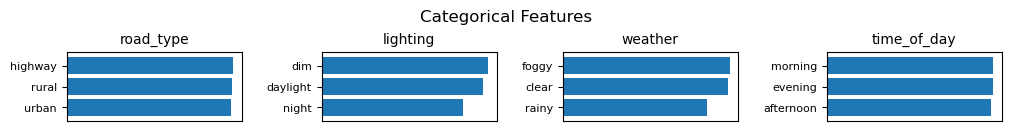

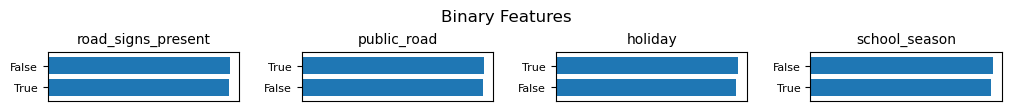

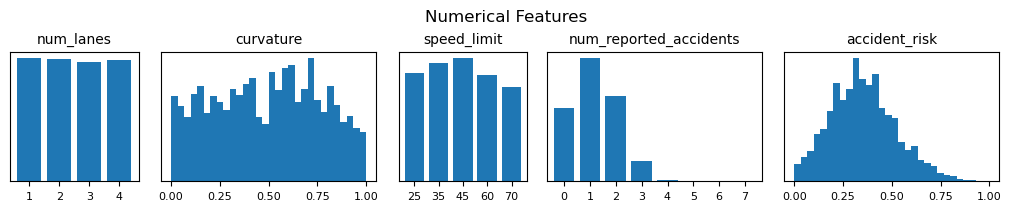

In [4]:
# Data Exploration Visualizations

# Categorical Features
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 1.2), constrained_layout=True, gridspec_kw={"wspace": 0.1})
fig.suptitle("Categorical Features", fontsize=12)
for ax, f in zip(axes, f_cat):
    subplot_hbar(ax, df_train_raw, f)
plt.show()


# Binary Features
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 1), constrained_layout=True, gridspec_kw={"wspace": 0.1})
fig.suptitle("Binary Features", fontsize=12)
for ax, f in zip(axes, f_bin):
    subplot_hbar(ax, df_train_raw, f)
plt.show()

# Numerical Features
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 2), constrained_layout=True, gridspec_kw={"wspace": 0.1, "width_ratios":[.6, 1, .6, 1, 1]})
fig.suptitle("Numerical Features", fontsize=12)
for ax, f in zip(axes.flat, f_num_raw):
    if f in f_num_disc:
        subplot_bar(ax, df_train_raw, f)
    else:
        subplot_hist(ax, df_train_raw, f)
plt.show()

### Feature Engineering

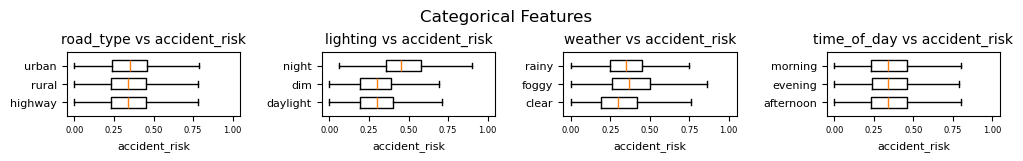

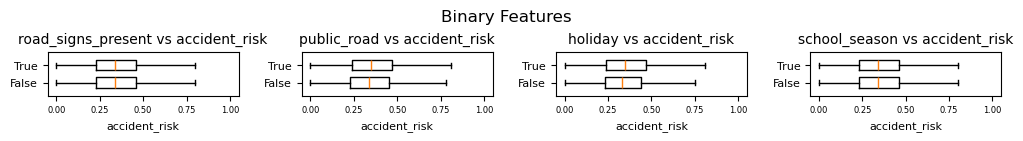

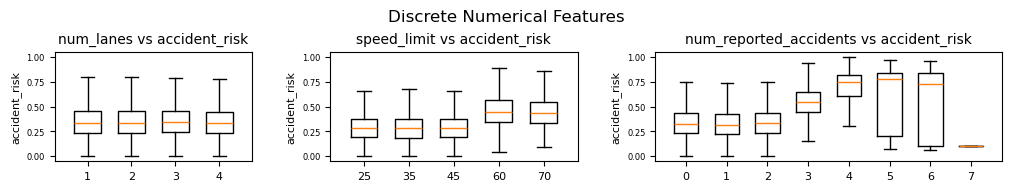

In [5]:
# Data vs target value distribution visualizations

# Categorical Features
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 1.5), constrained_layout=True, gridspec_kw={"wspace": 0.1})
fig.suptitle("Categorical Features", fontsize=12)
for ax, f in zip(axes, f_cat):
    subplot_hboxplot(ax, df_train, f, df_target)
plt.show()

# Binary Features
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 1.3), constrained_layout=True, gridspec_kw={"wspace": 0.1})
fig.suptitle("Binary Features", fontsize=12)
for ax, f in zip(axes, f_bin):
    subplot_hboxplot(ax, df_train, f, df_target)
plt.show()

# Discrete Numerical Features
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 1.8), constrained_layout=True, gridspec_kw={"wspace": 0.1, "width_ratios":[.8, 1, 1.4]})
fig.suptitle("Discrete Numerical Features", fontsize=12)
for ax, f in zip(axes.flat, f_num_disc):
    subplot_boxplot(ax, df_train, f, df_target)
plt.show()


In [6]:
# Feature Engineering

# Helper functions
def sigmoid(x): return  1 / (1 + np.exp(3-x))
light_level = {}
light_level['weather'] = {'rainy':.2, 'clear':.4, 'foggy':.0}
light_level['lighting'] = {'daylight':.6, 'dim':.6, 'night':.0} 


# Add new features
for df in [df_train, df_test]:
    
    df['light_level'] = .0
    for f in ['weather', 'lighting']:    
        df['light_level'] += df[f].map(light_level[f])

    df['num_reported_accidents_sigmoid'] = sigmoid(df['num_reported_accidents'])

    df['speed_limit_high'] = df['speed_limit'] >= 60


# Update list of fields
f_num += ['light_level', 'num_reported_accidents_sigmoid']
f_bin += ['speed_limit_high']


df_train.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,light_level,num_reported_accidents_sigmoid,speed_limit_high
id,,,,,,,,,,,,,,,
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.8,0.119203,False
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,1.0,0.047426,False
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,1.0,0.268941,True
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.8,0.119203,False
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.6,0.119203,True


### Feature Encoding

In [7]:
# Binary Encoding

for f in f_bin:
    df_train[f] = df_train[f].astype('float')
    df_test[f] = df_test[f].astype('float')


# One-hot Encoding

cat_encoder = OneHotEncoder(sparse_output=False)
cat_encoder.fit(df_train[f_cat])
f_cat_encoded = cat_encoder.get_feature_names_out(f_cat)
cat_encoded_df_train = pd.DataFrame(cat_encoder.transform(df_train[f_cat]), columns=cat_encoder.get_feature_names_out(f_cat))
cat_encoded_df_test = pd.DataFrame(cat_encoder.transform(df_test[f_cat]), columns=cat_encoder.get_feature_names_out(f_cat), index=df_test.index)

df_train = pd.concat([df_train, cat_encoded_df_train], axis=1).drop(f_cat, axis=1)
df_test = pd.concat([df_test, cat_encoded_df_test], axis=1).drop(f_cat, axis=1)

df_train.head()

,num_lanes,curvature,speed_limit,road_signs_present,public_road,holiday,school_season,num_reported_accidents,light_level,num_reported_accidents_sigmoid,...,road_type_urban,lighting_daylight,lighting_dim,lighting_night,weather_clear,weather_foggy,weather_rainy,time_of_day_afternoon,time_of_day_evening,time_of_day_morning
0,2,0.06,35,0.0,1.0,0.0,1.0,1,0.8,0.119203,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,4,0.99,35,1.0,0.0,1.0,1.0,0,1.0,0.047426,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,4,0.63,70,0.0,1.0,1.0,0.0,2,1.0,0.268941,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,4,0.07,35,1.0,1.0,0.0,0.0,1,0.8,0.119203,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1,0.58,60,0.0,0.0,1.0,0.0,1,0.6,0.119203,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### Data Normalization

In [8]:
# Min-max Scaling

num_scaler = MinMaxScaler()
num_scaler.fit(df_train[f_num])
num_scaler_df_train = pd.DataFrame(num_scaler.transform(df_train[f_num]))
num_scaler_df_test = pd.DataFrame(num_scaler.transform(df_test[f_num]), index=df_test.index)

for i, f in enumerate(f_num):
    df_train[f] = num_scaler_df_train[i]
    df_test[f] = num_scaler_df_test[i]

df_train.head()

,num_lanes,curvature,speed_limit,road_signs_present,public_road,holiday,school_season,num_reported_accidents,light_level,num_reported_accidents_sigmoid,...,road_type_urban,lighting_daylight,lighting_dim,lighting_night,weather_clear,weather_foggy,weather_rainy,time_of_day_afternoon,time_of_day_evening,time_of_day_morning
0,0.333333,0.06,0.222222,0.0,1.0,0.0,1.0,0.142857,0.8,0.076801,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1.000000,0.99,0.222222,1.0,0.0,1.0,1.0,0.000000,1.0,0.000000,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.000000,0.63,1.000000,0.0,1.0,1.0,0.0,0.285714,1.0,0.237019,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.000000,0.07,0.222222,1.0,1.0,0.0,0.0,0.142857,0.8,0.076801,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.000000,0.58,0.777778,0.0,0.0,1.0,0.0,0.142857,0.6,0.076801,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### Principal Component Analysis

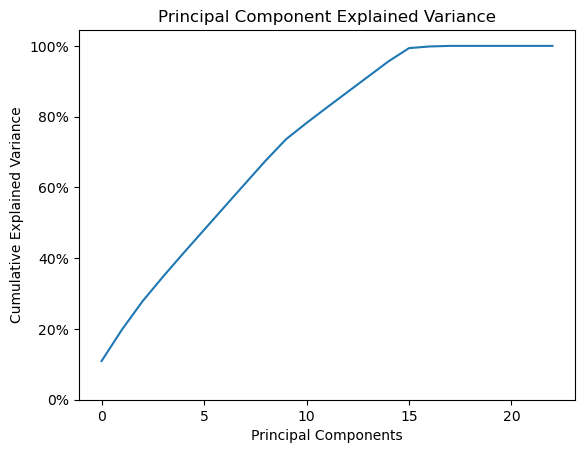

In [9]:
# Principal Component Analysis

# Normalize the data to standard normal gaussian
normalizer = StandardScaler()
normalizer.fit(df_train)
df_train_normalized = pd.DataFrame(normalizer.transform(df_train), columns=df_train.keys())
df_test_normalized = pd.DataFrame(normalizer.transform(df_test), columns=df_test.keys(), index = df_test.index)


# Perform PCA on normalized data
pca = PCA()
pca.fit(df_train_normalized)
df_train_pca = pd.DataFrame(pca.transform(df_train_normalized), columns=[f'PC{i}' for i in range(1, 24)])
df_test_pca = pd.DataFrame(pca.transform(df_test_normalized), columns=[f'PC{i}' for i in range(1, 24)], index = df_test.index)


# Plot the explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Principal Component Explained Variance")
plt.xlabel("Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.yticks(np.arange(6)/5, [f'{i*20}%' for i in range(6)])
plt.show()

## Part 3: Model Exploration

In [10]:
# Function to calculate RMSE for 5-fold cross-validation
    
kf = KFold(n_splits=5, shuffle=True, random_state=0)

def calculate_rmse(model, X, y):

    rmse = []
    
    for tr, ts in kf.split(X):
        X_train, X_test = X.iloc[tr], X.iloc[ts]
        y_train, y_test = y.iloc[tr], y.iloc[ts]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
        rmse_k = root_mean_squared_error(y_test, y_pred)
        rmse.append(rmse_k)

    return np.mean(rmse)

### Linear Regression

In [11]:
# Linear Regression

model_LR = LinearRegression()
rmse_LR = calculate_rmse(model_LR, df_train, df_target)
print(f"RMSE for linear regression: {rmse_LR:.7f}.")

model_Ridge = Ridge(alpha=0.5)
rmse_Ridge = calculate_rmse(model_Ridge, df_train, df_target)
print(f"RMSE for regularized linear regression: {rmse_Ridge:.7f}.")

RMSE for linear regression: 0.0591572.
RMSE for regularized linear regression: 0.0591572.


### K-Nearest Neighbor

In [12]:
# KNN model pipeline
# Get the KNN uniform and weighted distance 5-fold cross-validation score
# Set the desired max_neighbor and it will return all scores for k from 2 until max_neighbor  

def knn_kfold(X, y, max_neighbor=5, n_jobs=1):
    
    print(f"Initializing KNN model training for max_neighbor={max_neighbor}.")
    model = KNeighborsRegressor(n_neighbors=max_neighbor, n_jobs=n_jobs)
    rmse_u = {}
    rmse_w = {}
    
    for i, (tr, ts) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[tr], X.iloc[ts]
        y_train, y_test = y.iloc[tr], y.iloc[ts]
        
        print(f"Training and evaluating fold #{i+1}...")
        model.fit(X_train, y_train)
        distances, indices = model.kneighbors(X_test)
    
        for k in range(2, max_neighbor+1):
            if k not in rmse_u.keys():
                rmse_u[k] = []
                rmse_w[k] = []
                
            idx_k = indices[:, :k]
            
            y_pred = np.mean(np.array(y_train)[idx_k], axis=1)
            rmse_k = root_mean_squared_error(y_test, y_pred)
            rmse_u[k].append(rmse_k)
    
            dist_k = distances[:, :k]
            dist_k = distances[:, :k]
            weights = 1 / (dist_k + 1E-12)
            y_pred = np.sum(np.array(y_train)[idx_k]*weights, axis=1)/np.sum(weights, axis=1)
            rmse_k = root_mean_squared_error(y_test, y_pred)
            rmse_w[k].append(rmse_k)

    for k in range(2, max_neighbor+1):
        rmse_u[k] = np.mean(rmse_u[k])
        rmse_w[k] = np.mean(rmse_w[k])
    
    print(f"Training completed.")
    return rmse_u, rmse_w

In [28]:
# Uncomment this block to train amd evaluate the KNN model

'''
rmse_u, rmse_w = knn_kfold(df_train, df_target, max_neighbor=20, n_jobs=6)
save_var([rmse_u, rmse_w], 'rmse_knn')
'''

a = 0

In [29]:
# Uncomment this block to train amd evaluate the KNN model on PCA data

'''
rmse_u_pca = {}
rmse_w_pca = {}
for pc in [1,2,3,5,7,10,12,15,20]:
    PCAs = [f'PC{i+1}' for i in range(pc)]
    print(f'Training for PCA with {pc} principal component...')
    rmse_u_pca[pc], rmse_w_pca[pc] = knn_kfold(df_train_pca[PCAs], df_target, max_neighbor=50)

save_var([rmse_u_pca, rmse_w_pca], 'rmse_knn_pca')
'''

a = 0

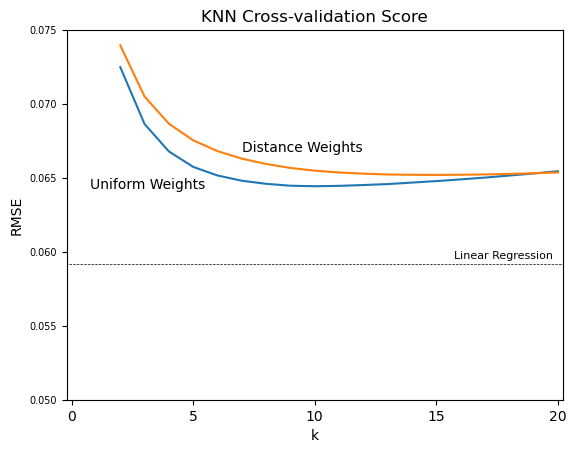

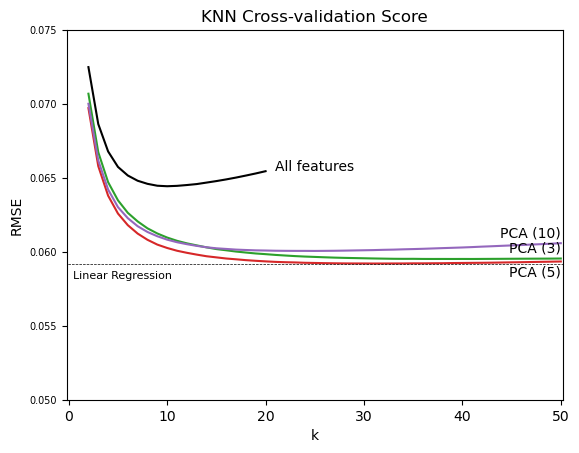

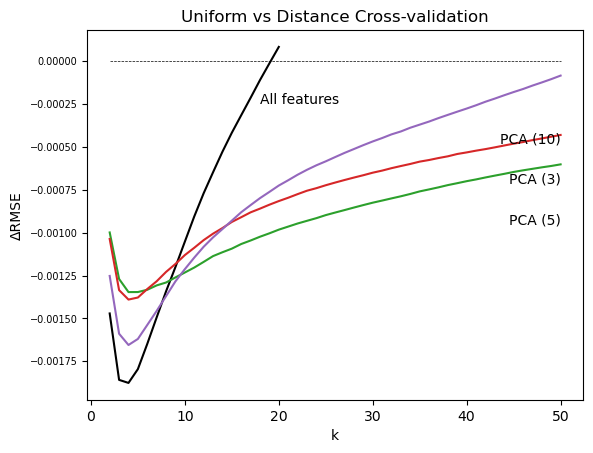

In [15]:
# Training Results

# KNN using df_normal data: uniform vs distance weights

rmse_u, rmse_w = load_var('rmse_knn')

x = rmse_u.keys()
y = rmse_u.values()
plt.plot(x, y, label=f'Uniform')
plt.text(5.5, list(y)[-1]-0.0012, f"Uniform Weights", horizontalalignment='right')

x = rmse_w.keys()
y = rmse_w.values()
plt.plot(x, y, label=f'Distance')
plt.text(7, list(y)[-1]+0.0014, f"Distance Weights", horizontalalignment='left')

plt.plot([-5,60], [0.05915]*2, 'k--', lw=0.5)
plt.text(20-0.2, 0.0595, f"Linear Regression", horizontalalignment='right', fontsize=8)

plt.title("KNN Cross-validation Score")
plt.xlabel("k")
plt.ylabel("RMSE")
plt.xticks(np.arange(0,21,5))
plt.xlim(-0.2, 20.2)
plt.ylim(0.05,0.075)
plt.yticks(fontsize=7)
plt.show()



# KNN using df_pca

rmse_u_pca, rmse_w_pca = load_var('rmse_knn_pca')

x = rmse_u.keys()
y = rmse_u.values()
plt.plot(x, y,lw=0.1)
plt.plot(x, y,lw=0.1)
plt.plot(x, y,'k')
plt.text(21, list(y)[-1], f"All features")

for p in [3,5,10]:
    x = rmse_u_pca[p].keys()
    y = rmse_u_pca[p].values()
    plt.plot(x, y, label=f'p{p}')
    if p in [3,10]:
        plt.text(50, list(y)[-1]+0.0004, f"PCA ({p})", horizontalalignment='right')
    else:
        plt.text(50, list(y)[-1]-0.0010, f"PCA ({p})", horizontalalignment='right')

plt.plot([-5,60], [0.05915]*2, 'k--', lw=0.5)
plt.text(0+0.4, 0.0582, f"Linear Regression", horizontalalignment='left', fontsize=8)

plt.title("KNN Cross-validation Score")
plt.xlabel("k")
plt.yticks(fontsize=7)
plt.xlim(-0.2, 50.2)
plt.ylim(0.05,0.075)
plt.ylabel("RMSE")
plt.show()


# KNN uniform vs distance weighted using df_pca

x = rmse_u.keys()
y = [rmse_u[i] - rmse_w[i] for i in x]
plt.plot(x, y,lw=0.1)
plt.plot(x, y,lw=0.1)
plt.plot(x, y,'k')

for p in [3,5,10]:
    x = rmse_u_pca[p].keys()
    y = [rmse_u_pca[p][i] - rmse_w_pca[p][i] for i in x]
    plt.plot(x, y, label=f'p{p}')
    
plt.plot(x, [0]*49, 'k--', lw=0.5)

plt.text(18, -0.00025, f"All features")
plt.text(50, -0.00048, f"PCA (10)", horizontalalignment='right')
plt.text(50, -0.00071, f"PCA (3)", horizontalalignment='right')
plt.text(50, -0.00095, f"PCA (5)", horizontalalignment='right')
#plt.suptitle("Uniform vs Distance Weight Cross-validation Score Difference")
plt.title("Uniform vs Distance Cross-validation")
plt.xlabel("k")
plt.ylabel("ΔRMSE")
plt.yticks(fontsize=7)
plt.show()

### Binary Tree

In [16]:
# Binary Tree model pipeline
# Set the max_depth, min_samples_split, min_samples_split to adjust model complexity

def decision_tree_kfold(X, y, max_depth=None, min_samples_split=2, min_samples_leaf=1):
    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf,  
        random_state=0
    )

    rmse = []
    for tr, ts in kf.split(X):
        X_train, X_test = X.iloc[tr], X.iloc[ts]
        y_train, y_test = y.iloc[tr], y.iloc[ts]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
        rmse_k = root_mean_squared_error(y_test, y_pred)
        rmse.append(rmse_k)
        #print(model.get_depth(), model.get_n_leaves())

    return np.mean(rmse)

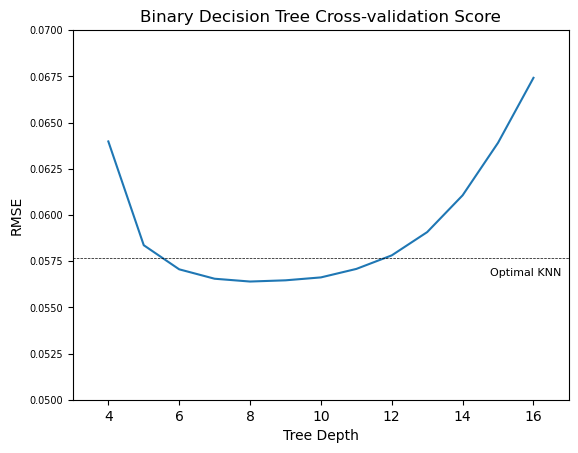

In [17]:
# Uncomment this block to train amd evaluate the Binary Tree model for various tree depth

'''
rmse_tree = {}
for d in range(4,17):
    rmse_tree[d] = decision_tree_kfold(df_train_numerical, df_target, max_depth=d)
    save_var(rmse_tree, 'rmse_tree')
'''


# Result

rmse_tree = load_var('rmse_tree')
x, y = rmse_tree.keys(), rmse_tree.values()
plt.plot(x,y)

plt.title("Binary Decision Tree Cross-validation Score")
plt.xlabel("Tree Depth")
plt.ylabel("RMSE")
plt.yticks(fontsize=7)
plt.xlim(3,17)
plt.ylim(0.05, 0.07)
plt.plot([0,20], [0.05767]*2, 'k--', lw=0.5)
plt.text(17-0.2, 0.0567, f"Optimal KNN", horizontalalignment='right', fontsize=8)
plt.show()

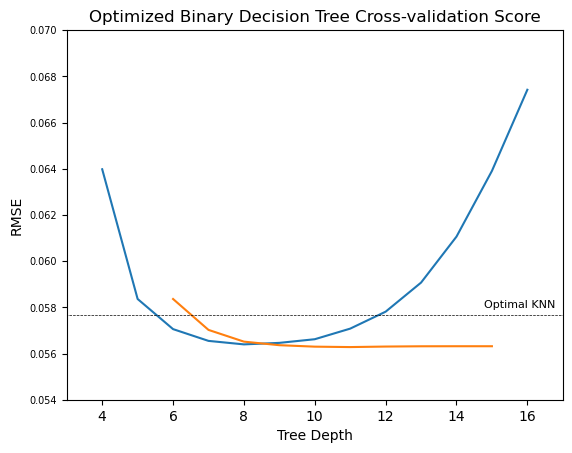

In [18]:
# Uncomment this block to train amd evaluate the Binary Tree model with optimized min_samples_split and min_samples_leaf

'''
rmse_tree_optimized = {}
for d in range(6,17):
    rmse_tree_optimized[d] = []

    for ss in [2,5,10,50,100,500,1000]:
        for sl in [1,2,5,10]:
            rmse = decision_tree_kfold(df_train_numerical, df_target, max_depth=d, min_samples_split=ss, min_samples_leaf=sl)
            rmse_tree_optimized[d].append([ss, sl, rmse])
            save_var(rmse_tree_optimized, 'rmse_tree_optimized')
'''


# Result

rmse_tree = load_var('rmse_tree')
x, y = rmse_tree.keys(), rmse_tree.values()
plt.plot(x,y)

rmse_tree_optimized = load_var('rmse_tree_optimized')
x = rmse_tree_optimized.keys()
y = [min(np.array(rmse_tree_optimized[i])[:,-1]) for i in x]
plt.plot(x,y)

plt.title("Optimized Binary Decision Tree Cross-validation Score")
plt.xlabel("Tree Depth")
plt.ylabel("RMSE")
plt.yticks(fontsize=7)
plt.xlim(3,17)
plt.ylim(0.054, 0.07)
plt.plot([0,20], [0.05767]*2, 'k--', lw=0.5)
plt.text(17-0.2, 0.058, f"Optimal KNN", horizontalalignment='right', fontsize=8)
plt.show()

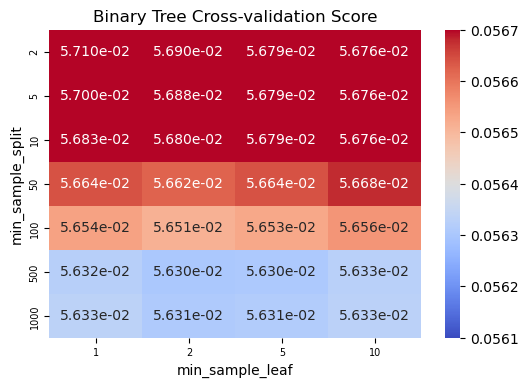

In [19]:
# Tree RMSE heatmap

d = 12
rmse_tree = load_var('rmse_tree_optimized')[d]

hm_dbt = pd.DataFrame(rmse_tree, columns=['min_sample_split', 'min_sample_leaf', 'RMSE'])
pivot = hm_dbt.pivot(index='min_sample_split', columns='min_sample_leaf', values='RMSE')
plt.figure(figsize=(6,4))
#plt.figure(figsize=(6,9))
sn.heatmap(pivot, annot=True, cmap='coolwarm', fmt=".3e", vmax = 0.0567, vmin = 0.0561)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title(f"max_depth={d}")
plt.title("Binary Tree Cross-validation Score")
plt.show()

### Random Forest

In [20]:
# Random Forest model pipeline
# Set the n_estimators, max_depth, min_samples_split, min_samples_split to adjust model complexity

def random_forest_kfold(X, y, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, n_jobs=-1):
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf,  
        n_jobs=n_jobs,
        random_state=0
    )

    rmse = []
    for tr, ts in kf.split(X):
        X_train, X_test = X.iloc[tr], X.iloc[ts]
        y_train, y_test = y.iloc[tr], y.iloc[ts]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
        rmse_k = root_mean_squared_error(y_test, y_pred)
        rmse.append(rmse_k)


    return np.mean(rmse)

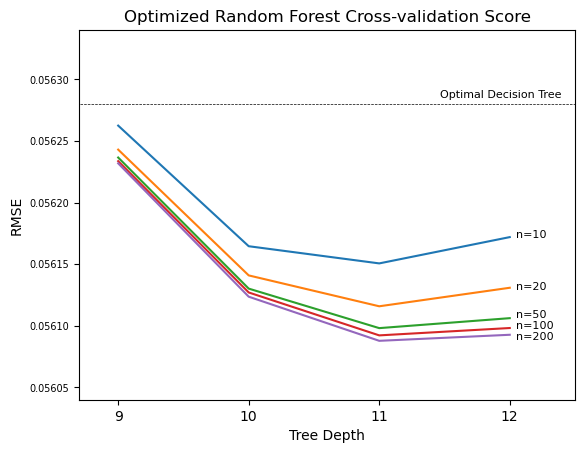

In [21]:
# Uncomment this block to train and hyperparameter tune random forest model

'''
rmse = {}
for n in [10, 20, 50, 100, 200]:
    rmse[n] = {}
    for d in [9, 10, 11, 12]:
        rmse[n][d] = []
        for ss in [2, 5, 10, 50, 100, 500, 1000]:
            for sl in [1, 2, 5, 10]:
                rmse[n][d].append([ss, sl, 
                                   random_forest_kfold(
                                       df_train_numerical, 
                                       df_target, 
                                       n_estimators=n,
                                       max_depth=d, 
                                       min_samples_leaf=sl, 
                                       min_samples_split=ss
                                   )
                                  ])    
                save_var(rmse, 'rmse_forest')
                
        print(n, d, min(rmse[n][d], key=lambda x: x[2]))

'''


# Result

rmse_forest = load_var('rmse_forest')

for n, tree in rmse_forest.items():
    x = [9, 10, 11, 12]
    y = [min(np.array(tree[i])[:,-1]) for i in x]
    plt.plot(x,y, label=n)
    delta = {10:2E-6,20:1E-6,50:3E-6,100:2E-6,200:-2E-6}
    plt.text(x[-1]+0.05,y[-1]+delta[n], f"n={n}", verticalalignment='center',fontsize=8)
        
plt.title("Optimized Random Forest Cross-validation Score")
plt.xlabel("Tree Depth")
plt.xticks(np.arange(8,13))
plt.ylabel("RMSE")
plt.yticks(fontsize=7)
plt.xlim(8.7,12.5)
plt.ylim(0.05604, 0.05634)
plt.plot([0,20], [0.05628]*2, 'k--', lw=0.5)
plt.text(12.5-0.1, 0.05628+0.000005, f"Optimal Decision Tree", horizontalalignment='right', fontsize=8)
plt.show()

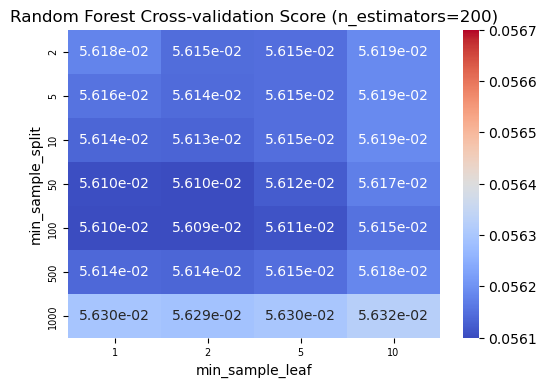

In [22]:
# Forest RMSE heatmap

rmse_tree = load_var('rmse_forest')[200]

i = 12
hm_dbt = pd.DataFrame(rmse_tree[i], columns=['min_sample_split', 'min_sample_leaf', 'RMSE'])
pivot = hm_dbt.pivot(index='min_sample_split', columns='min_sample_leaf', values='RMSE')
plt.figure(figsize=(6,4))
#plt.figure(figsize=(6,9))
sn.heatmap(pivot, annot=True, cmap='coolwarm', fmt=".3e", vmax = 0.0567, vmin = 0.0561)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title(f"max_depth={i}")
plt.title("Random Forest Cross-validation Score (n_estimators=200)")
plt.show()

### LightGBM

In [23]:
# Light GBM model pipeline using Optuna hyperparameter tuning
# Set the hyperparameters range in the objective function

def objective(trial):

    params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": "gbdt",
        "n_estimators": trial.suggest_int("n_estimators", 500, 2000),        
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 16, 1023, log=True),
        "max_depth": trial.suggest_int("max_depth", 5, 25),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "random_state": 0,
        "n_jobs":-1,
    }

    model = LGBMRegressor(**params, verbose=-1)

    rmse = []
    for tr, ts in kf.split(df_train):
        X_train, X_test = df_train_ordinal.iloc[tr], df_train_ordinal.iloc[ts]
        y_train, y_test = df_target.iloc[tr], df_target.iloc[ts]
        f_cat_ = f_cat + f_bin
        model.fit(X_train, y_train, categorical_feature=f_cat_)
        y_pred = model.predict(X_test)
    
        rmse_k = root_mean_squared_error(y_test, y_pred)
        rmse.append(rmse_k)

    return np.mean(rmse)

In [24]:
# Uncomment this block to train and hyperparameter tune light GBM model
# Set new_study = TRUE if start from scratch, FALSE to continuing the study

new_study = False

'''
if new_study:
    study = optuna.create_study(direction="minimize")
else:
    study = load_var('optuna_study')


optuna.logging.set_verbosity(optuna.logging.ERROR)

print(f"[{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}] Starting optimizing...")
for i in range(100):
    study.optimize(objective, n_trials=5)
    save_var(study, 'study')
    msg = f"[{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}] Sampling {len(study.trials)} parameters, "
    msg += f"best RMSE {study.best_value:.6f} on study {study.best_trial.number}."
    print(msg)
    
print("Best params:", study.best_params)
'''

# Result
study = load_var('optuna_study')
trials = []
for i in study.get_trials():
    trials.append(i.params)
    trials[-1]['rmse'] = i.value

df_trials = pd.DataFrame(trials)
df_trials.sort_values(by='rmse', ascending=True, inplace=True)
df_trials.head(10)

,n_estimators,learning_rate,num_leaves,max_depth,min_child_samples,min_split_gain,subsample,subsample_freq,colsample_bytree,reg_alpha,reg_lambda,rmse
611,1855,0.006198,170,19,7,0.000881,0.888358,10,0.661356,0.000008,3.170762e-05,0.055960
764,1813,0.006323,168,17,6,0.000751,0.904919,10,0.676219,0.000666,3.864945e-02,0.055961
578,1870,0.006086,145,20,5,0.001112,0.876415,10,0.673590,0.000958,2.416479e-08,0.055962
583,1921,0.005989,160,19,5,0.000964,0.880634,10,0.670041,0.001150,2.963877e-08,0.055962
815,1911,0.005027,194,19,5,0.000722,0.877430,10,0.692554,0.000570,2.209926e-08,0.055962
630,1971,0.005908,153,19,7,0.001056,0.892376,10,0.669387,0.000003,8.600309e-05,0.055962
543,1933,0.006007,134,17,5,0.001114,0.865652,10,0.676506,0.000037,3.795098e-08,0.055964
804,1928,0.004816,173,18,13,0.000930,0.889631,10,0.696575,0.000899,1.515276e-08,0.055965
567,1920,0.006350,144,19,7,0.002078,0.879320,10,0.680481,0.000729,1.024049e-08,0.055965
588,1926,0.006832,165,20,7,0.001048,0.866804,10,0.676080,0.000930,5.257382e-08,0.055965


In [25]:
df_trials.iloc[0]

n_estimators         1855.000000
learning_rate           0.006198
num_leaves            170.000000
max_depth              19.000000
min_child_samples       7.000000
min_split_gain          0.000881
subsample               0.888358
subsample_freq         10.000000
colsample_bytree        0.661356
reg_alpha               0.000008
reg_lambda              0.000032
rmse                    0.055960
Name: 611, dtype: float64

### Part 3: Model Submission

In [30]:
# Random Forest Model

final_model = RandomForestRegressor(
    n_estimators=1000,
    max_depth=11,
    min_samples_split=50, 
    min_samples_leaf=2,  
    n_jobs=-1,
    random_state=0
)
final_model.fit(df_train, df_target)
y_pred = final_model.predict(df_test)
submission = pd.DataFrame(y_pred, index=df_test.index, columns=['accident_risk'])
submission.to_csv(f'submissions/final_submission_forest.csv', index=True)

In [31]:
# Light GBM Model

params = dict(df_trials.iloc[0])
for key in ['n_estimators', 'max_depth', 'num_leaves', 'min_child_samples', 'subsample_freq']:
    params[key] = int(params[key])

final_model = LGBMRegressor(**params)
final_model.fit(df_train, df_target, categorical_feature=f_cat+f_bin)
y_pred = final_model.predict(df_test_ordinal)
submission = pd.DataFrame(y_pred, index=df_test.index, columns=['accident_risk'])
submission.to_csv(f'submissions/final_submission_lgbm.csv', index=True)